In [490]:
# import the necessary packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

In [491]:
class LeNet(Module):
	def __init__(self, numChannels, classes):
		# call the parent constructor
		super(LeNet, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
		self.relu1 = ReLU()
		self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize second set of CONV => RELU => POOL layers
		self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
		self.relu2 = ReLU()
		self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		# initialize first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=186050, out_features=64)
		self.relu3 = ReLU()
		# initialize our softmax classifier
		self.fc2 = Linear(in_features=64, out_features=classes)
		self.logSoftmax = LogSoftmax(dim=1)
	def forward(self, x):
		# pass the input through our first set of CONV => RELU =>
		# POOL layers
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
		x = self.fc2(x)
		output = self.logSoftmax(x)
		# return the output predictions
		return output

In [492]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import Adam
from torch import nn
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time
import cv2
import os

In [493]:
# Simulate command-line arguments inside the notebook
args_list = ['-m', 'model_output.h5', '-p', 'plot_output.png']

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", type=str, required=True,
	help="path to output trained model", default='model_output.h5')
ap.add_argument("-p", "--plot", type=str, required=True,
	help="path to output loss/accuracy plot", default='plot_output.png')
args = vars(ap.parse_args(args_list))

In [494]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [495]:
# new class to replace KMNIST with our data
class CustomFolderDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        """
        Args:
            root_dirs (list or str): One or more root directories containing class-named subfolders.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        if isinstance(root_dirs, str):
            root_dirs = [root_dirs]
        
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        
        # Collect all unique classes across all roots
        all_classes = set()
        for root in root_dirs:
            all_classes.update(os.listdir(root))
        self.classes = sorted(all_classes)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collect samples from each root directory
        for root in root_dirs:
            for cls_name in os.listdir(root):
                for i in range(2 if cls_name == "waldo" else 1): # Attempting to oversample
                    cls_folder = os.path.join(root, cls_name)
                    if not os.path.isdir(cls_folder):
                        continue
                    for fname in os.listdir(cls_folder):
                        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                            path = os.path.join(cls_folder, fname)
                            label = self.class_to_idx[cls_name]
                            self.samples.append((path, label))

        self.targets = [label for _, label in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        shaped_image = cv2.resize(image, dsize=(256, 256))
        
        if self.transform:
            shaped_image = self.transform(shaped_image)
        
        return shaped_image, label

In [496]:
# load the dataset
print("[INFO] loading the dataset...")
trainData = CustomFolderDataset(root_dirs=['./Hey-Waldo/256'], transform=ToTensor())
testData = CustomFolderDataset(root_dirs=['./Hey-Waldo/256'], transform=ToTensor())
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = len(trainData) - numTrainSamples
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading the dataset...
[INFO] generating the train/validation split...


In [497]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [498]:
# Unused code that we could make a custom CNN from (sourced from HW 4)
# Assumed start of 64 pixels
def createCnnSequential():
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(4096,256),
        nn.ReLU(),
        nn.Linear(256, 2)
    )

In [499]:
# initialize the model
from sklearn.utils import compute_class_weight

print("[INFO] initializing the model...")
# model = createCnnSequential().to(device)
model = LeNet(
	numChannels=3,
	classes=len(trainData.dataset.classes)).to(device)

# Access correct targets from the split subset
full_targets = trainData.dataset.targets
train_targets = [full_targets[i] for i in trainData.indices]

# Compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_targets),
    y=train_targets
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.CrossEntropyLoss(weight=class_weights)
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# loop over our epochs
for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()
	# switch off autograd for evaluation
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
		avgValLoss, valCorrect))

# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] initializing the model...
[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 5.080133, Train accuracy: 0.6705
Val loss: 1.371808, Val accuracy: 0.8391

[INFO] EPOCH: 2/10
Train loss: 0.821917, Train accuracy: 0.6590
Val loss: 1.637755, Val accuracy: 0.8391

[INFO] EPOCH: 3/10
Train loss: 0.925514, Train accuracy: 0.8391
Val loss: 1.326802, Val accuracy: 0.8391

[INFO] EPOCH: 4/10
Train loss: 0.839338, Train accuracy: 0.8429
Val loss: 1.344575, Val accuracy: 0.6897

[INFO] EPOCH: 5/10
Train loss: 0.760000, Train accuracy: 0.8276
Val loss: 1.493747, Val accuracy: 0.2184

[INFO] EPOCH: 6/10
Train loss: 0.656861, Train accuracy: 0.7011
Val loss: 1.189842, Val accuracy: 0.7241

[INFO] EPOCH: 7/10
Train loss: 0.538240, Train accuracy: 0.8391
Val loss: 1.418955, Val accuracy: 0.4598

[INFO] EPOCH: 8/10
Train loss: 0.606346, Train accuracy: 0.7395
Val loss: 0.917681, Val accuracy: 0.7931

[INFO] EPOCH: 9/10
Train loss: 0.353269, Train accuracy: 0.9349
Val loss: 0.882660, Val 

In [500]:
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())

# generate a classification report
print(classification_report(testData.targets,
	np.array(preds), target_names=testData.classes))

[INFO] evaluating network...
              precision    recall  f1-score   support

    notwaldo       1.00      0.81      0.90       286
       waldo       0.54      1.00      0.70        62

    accuracy                           0.85       348
   macro avg       0.77      0.91      0.80       348
weighted avg       0.92      0.85      0.86       348



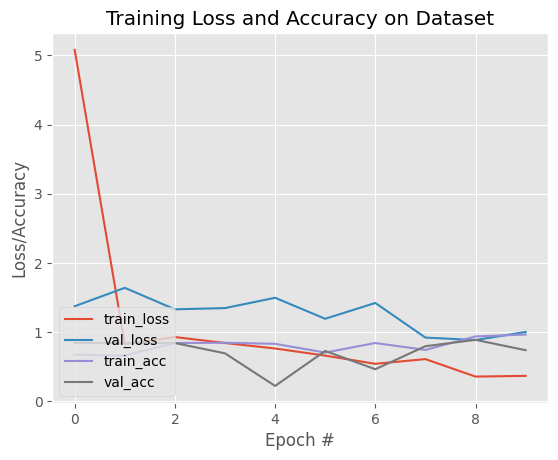

In [501]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

In [502]:
import tensorflow as tf
import numpy as np
import cv2
import os
%matplotlib inline
from matplotlib import pyplot as plt
from torchvision import transforms

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


In [503]:
def sliding_window(image, step=32, window_size=(256, 256)):
    for y in range(0, image.shape[0] - window_size[1], step):
        for x in range(0, image.shape[1] - window_size[0], step):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [504]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

def detect_waldo_in_image(model, full_image, window_size=(256, 256), step=32, threshold=0.9):
    boxes = []

    for (x, y, window) in sliding_window(full_image, step=step, window_size=window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue  # Skip incomplete patches at the edge

        input_img = window[y:y+256, x:x+256]
        input_img = cv2.resize(window, (256, 256))
        
        # Normalize and reshape
        input_img = transform(input_img)  # [C, H, W], float32, range [0,1]
        input_img = input_img.unsqueeze(0)  # Add batch dimension -> [1, C, H, W]

        # Move to device (GPU or CPU)
        input_img = input_img.to(device)

        # Make prediction
        model.eval()  # Set model to eval mode
        with torch.no_grad():
            prediction = model(input_img)
            predicted_class = torch.argmax(prediction, dim=1).item()

        if predicted_class == 1:
            boxes.append((x, y, predicted_class))

    return boxes


In [505]:
img_path = "Hey-Waldo/original-images/1.jpg"
# img_path = "Hey-Waldo/256/waldo/1_1_1.jpg"
image = load_image(img_path)

In [506]:
x, y = 0, 0
test_window = image[y:y+256, x:x+256]  # Pick a spot you know Waldo is in
test_window = cv2.resize(test_window, (256, 256))

# Normalize and reshape
test_window = transform(test_window)  # [C, H, W], float32, range [0,1]
test_window = test_window.unsqueeze(0)  # Add batch dimension -> [1, C, H, W]

# Move to device (GPU or CPU)
test_window = test_window.to(device)

# Make prediction
model.eval()  # Set model to eval mode
with torch.no_grad():
    prediction = model(test_window)
    predicted_class = torch.argmax(prediction, dim=1).item()

print("Predicted class:", predicted_class)
print("Predicted label:", trainData.dataset.classes[predicted_class])
print("Raw model outputs:", prediction.cpu().numpy())

Predicted class: 0
Predicted label: notwaldo
Raw model outputs: [[-0.01767351 -4.044515  ]]


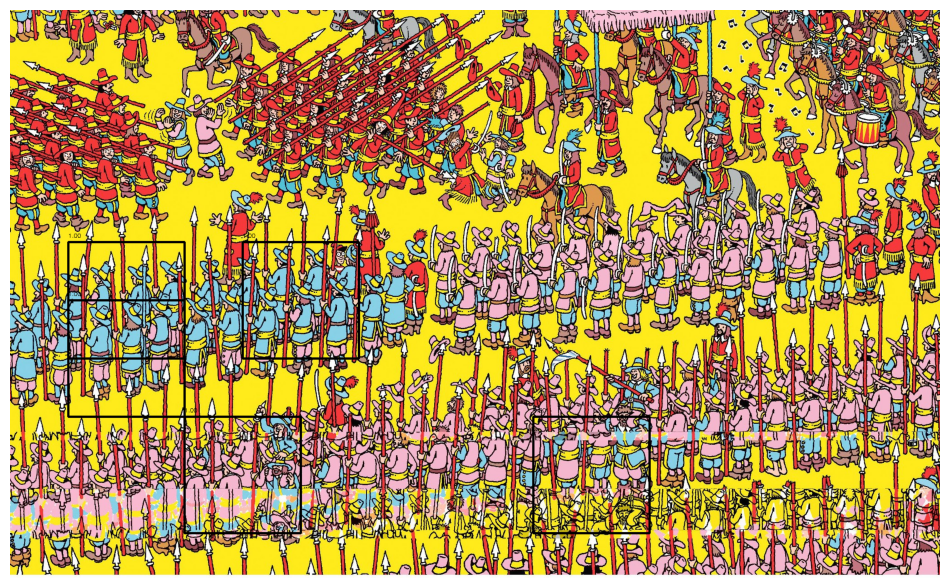

In [507]:
# Example threshold values
threshold = 0.7

# Multiply by 100000 to shift the decimal point
# threshold_display = int(threshold * 1000000)

# Display as 15 instead of 0.00015
# print(f"Threshold: {threshold_display}")

boxes = detect_waldo_in_image(model, image, window_size=(256, 256), step=128, threshold=threshold)
# for some reason every single bounding box has the same threshold value???

def draw_detections(image, boxes, window_size=(256, 256)):
    img_copy = image.copy()
    for (x, y, score) in boxes:
        cv2.rectangle(img_copy, (x, y), (x + window_size[0], y + window_size[1]), (0, 0, 0), 4)
        cv2.putText(img_copy, f"{float(score):.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
    return img_copy

result_image = draw_detections(image, boxes)

plt.figure(figsize=(12, 12))
plt.imshow(result_image)
plt.axis('off')
plt.show()